## Finite Element Method

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output
from scipy.sparse.linalg import spsolve

### 1. Gauss-Legendre Nodes

In [98]:
def gauss_legendre_1D(deg):
    """
    Calculate the Gauss-Legendre nodes and weights for the given number of points
    [nodes,weights] = 
    """
    nodes = []
    weights = []

    if deg == 1:
        nodes.append(0)
        weights.append(2)
    elif deg == 2:
        nodes.append(-0.5773502691896257)
        nodes.append(0.5773502691896257)
        weights.append(1)
        weights.append(1)
    elif deg == 3:
        nodes.append(-0.7745966692414834)
        nodes.append(0)
        nodes.append(0.7745966692414834)
        weights.append(0.5555555555555556)
        weights.append(0.8888888888888888)
        weights.append(0.5555555555555556)
    elif deg == 4:
        nodes.append(-0.8611363115940526)
        nodes.append(-0.3399810435848563)
        nodes.append(0.3399810435848563)
        nodes.append(0.8611363115940526)
        weights.append(0.3478548451374539)
        weights.append(0.6521451548625461)
        weights.append(0.6521451548625461)
        weights.append(0.3478548451374539)
    elif deg == 5:
        nodes.append(-0.906179845938664)
        nodes.append(-0.5384693101056831)
        nodes.append(0)
        nodes.append(0.5384693101056831)
        nodes.append(0.906179845938664)
        weights.append(0.2369268850561891)
        weights.append(0.4786286704993665)
        weights.append(0.5688888888888889)
        weights.append(0.4786286704993665)
        weights.append(0.2369268850561891)
    elif deg == 6:
        nodes.append(-0.932469514203152)
        nodes.append(-0.6612093864662645)
        nodes.append(-0.2386191860831969)
        nodes.append(0.2386191860831969)
        nodes.append(0.6612093864662645)
        nodes.append(0.932469514203152)
        weights.append(0.1713244923791704)
        weights.append(0.3607615730481386)
        weights.append(0.467913934572691)
        weights.append(0.467913934572691)
        weights.append(0.3607615730481386)
        weights.append(0.1713244923791704)
    elif deg == 7:
        nodes.append(-0.9491079123427585)
        nodes.append(-0.7415311855993945)
        nodes.append(-0.4058451513773972)
        nodes.append(0)
        nodes.append(0.4058451513773972)
        nodes.append(0.7415311855993945)
        nodes.append(0.9491079123427585)
        weights.append(0.1294849661688697)
        weights.append(0.2797053914892767)
        weights.append(0.3818300505051189)
        weights.append(0.4179591836734694)
        weights.append(0.3818300505051189)
        weights.append(0.2797053914892767)
        weights.append(0.1294849661688697)
    return nodes, weights

In [99]:
def gauss_legendre_2D(nglx, ngly):
    """
    Calculate the Gauss-Legendre nodes and weights for the given number of points
    [nodes,weights] = gauss_legendre_2D(nglx,ngly)
    nglx - number of gauss points in x direction
    ngly - number of gauss points in y direction
    nodes2 - vector of integration points
    weights2 - vector of weight coefficients 
    """
   
    
    if nglx > ngly:
        ngl = nglx
    else:
        ngl = ngly
        
    nodes2   = np.zeros((ngl,2))
    weights2 = np.zeros((ngl,2))
    
    [nodesx, weightsx] = gauss_legendre_1D(nglx)
    [nodesy, weightsy] = gauss_legendre_1D(ngly)
    
    for I in range(nglx):
        nodes2[I,0]   = nodesx[I]
        weights2[I,0] = weightsx[I]
        
    for J in range(ngly):
        nodes2[J,1]   = nodesy[J]
        weights2[J,1] = weightsy[J]
        
    
    return nodes2, weights2

### 1. Quadrilateral Elementary Matrix

#### Shape functions and derivatives in reference to $\xi, \eta$, reference element

In [100]:
def feisoq4(xi, eta, node): # Gauss points in xi, eta
    """
    compute the shape functions and their derivatives, for Q4 elements
    at integration point, in terms of natural coords (xi, eta)
    """
    #node 1 (-1, -1)
    #node 2 ( 1, -1)
    #node 3 ( 1,  1)
    #node 4 (-1,  1)
    #shape functions
    
    #initialize
    alpha     = np.zeros(4)
    dalphdxi  = np.zeros(4)
    dalphdeta = np.zeros(4)

    nodes = [(-1, -1), (1, -1), (1, 1), (-1, 1)]

    for i in range(4):
        c_xi, c_eta = nodes[i]  # coefficients before xi and eta (reference element)
    
        alpha[i] = 0.25 * (1 + c_xi * xi[node]) * (1 + c_eta * eta[node])

    # derivatives, dxi
        dalphdxi [i] = 0.25 * c_xi  * (1  + c_eta * eta[node])
    # deta
        dalphdeta[i] = 0.25 * c_eta * (1  + c_xi  * xi[node])


    # print(f"node: {node}; dalphdxi: {dalphdxi}\n")
    return alpha, dalphdxi, dalphdeta

#### Jacobian calculation

In [101]:
def fejacob2(nnel, dalphdxi, dalphdeta, xcoord, ycoord):
    """
    Calculation for the jacobian matrix
    nnel - number of nodes in the element
    dalphdxi -- derivatives of shape function w.r.t xi
    dalphdeta -- derivatives of shape function w.r.t eta 
    xcoord - x coordinate of the nodes
    ycoord - y coordinate of the nodes
    """
    #initialize
    jacob2 = np.zeros((2, 2))
#
    for i in range(nnel):
        jacob2[0,0] += dalphdxi[i]  * xcoord[i]
        jacob2[0,1] += dalphdeta[i] * xcoord[i]
        jacob2[1,0] += dalphdxi[i]  * ycoord[i]
        jacob2[1,1] += dalphdeta[i] * ycoord[i]
    
    return jacob2

#### Shape functions and derivatives in reference to $x, y$

In [102]:
def federiv2(nnel,dalphdxi,dalphdeta,invjacobt):
    """
    Calculation of the derivatives of the shape functions, with respect to x and y
    nnel - number of nodes in the element
    dalphdxi -- derivatives of shape function w.r.t xi
    dalphdeta -- derivatives of shape function w.r.t eta 
    invjacobt -- inverse of the transposed of the jacobian matrix
    """

    dxi_dx  = invjacobt[0, 0]
    deta_dx = invjacobt[0, 1]
    dxi_dy  = invjacobt[1, 0]
    deta_dy = invjacobt[1, 1]
    
    #initialize
    dalphdx = np.zeros(nnel)
    dalphdy = np.zeros(nnel)
    for i in range(nnel):
        dalphdx[i] = dalphdxi[i] * dxi_dx + dalphdeta[i] * deta_dx
        dalphdy[i] = dalphdxi[i] * dxi_dy + dalphdeta[i] * deta_dy

    return dalphdx, dalphdy

#### Calculation of a Quadrilateral elementary matrix (2D)

In [103]:
def elem_2D(xcoord, ycoord) -> np.ndarray:
    """
    Calculation for the elementary matrix of a quadrilateral element
    Variables description:
    k - element matrix
    point2 - integration points
    weight2 - weighting coeffs
    nglx - number of integration points along x
    ngly - number of integration points along y
    xcoord - x coordinate of the nodes
    ycoord - y coordinate of the nodes
    jocob2 - Jacobian matrix
    alpha - four-node quadrilateral shape functions
    dalphdxi -- derivatives of shape function w.r.t xi
    dalphdeta -- derivatives of shape function w.r.t eta
    dalphdx -- derivatives of shape function w.r.t x
    dalphdy -- derivatives of shape function w.r.t y
    """
    nnel = 4           # number of nodes per element
    ndof = 1           # degrees of freedom per node
    edof = nnel * ndof # degrees of freedom per element

    nglx = 2
    ngly = 2           # 2 points in each direction for Gauss integration

    [points, weights] = gauss_legendre_2D(nglx, ngly)

    k = np.zeros((edof, edof))

    nodes = [0, 1, 3, 2]

    ref_xi  = [-1/np.sqrt(3),  1/np.sqrt(3), 1/np.sqrt(3), -1/np.sqrt(3)]
    ref_eta = [-1/np.sqrt(3), -1/np.sqrt(3), 1/np.sqrt(3),  1/np.sqrt(3)]

    # print(points)

    #sampling over all the integration points
    for node in range(4):
    #

        al, daldxi, daldeta = feisoq4(ref_xi, ref_eta, node)
        # print(daldxi)
        # print(daldeta)
        # print("-----BREAK-----")
    #
        jacob2    = fejacob2(edof, daldxi, daldeta, xcoord, ycoord)
        detjacob  = np.linalg.det(jacob2)
        invjacob  = np.linalg.inv(jacob2)
        invjacobt = np.transpose(invjacob)
        # print(jacob2)

        daldx, daldy = federiv2(edof, daldxi, daldeta, invjacobt)

        #calculation of the matrix
        for i in range(edof):
            ii = nodes[i]
            for j in range(edof):
                jj = nodes[j]
                k[i, j] = (daldx[i] * daldx[j] + daldy[i] * daldy[j]) * detjacob
                # not += !!!!!

    return al, detjacob, k

### 2. Linear Elementary Matrix

#### 2.1. Shape functions and derivatives in reference to $\xi$, reference element

In [104]:
def feisoq2(xi): # Gauss points in xi, eta
    """
    compute the shape functions and their derivatives, for Q4 elements
    at integration point, in terms of natural coords (xi)
    """
    #node 1 (-1)
    #node 2 ( 1)
    #shape functions
    
    #initialize
    alpha     = np.zeros(2)
    dalphdxi  = np.zeros(2)

    nodes = [-1, 1]

    for i in range(2):
        c_xi = nodes[i]  # coefficients before xi and eta (reference element)
    
        alpha[i] = 0.5 * (1 + c_xi * xi)

    # derivatives, dxi
        dalphdxi[i] = 0.5 * c_xi


    return alpha, dalphdxi

#### 2.2. Jacobian calculation

In [105]:
def fe_detjacob(nnel, dalphdxi, xcoord, ycoord):
    """
    Calculation for the jacobian matrix
    nnel - number of nodes in the element
    dalphdxi -- derivatives of shape function w.r.t xi
    xcoord, ycoord - coordinates of the nodes
    """
    #initialize
    jacob = 0

    dxdxi = 0
    dydxi = 0

    for i in range(nnel):
        dxdxi += dalphdxi[i] * xcoord[i]
        dydxi += dalphdxi[i] * ycoord[i]
        
    jacob = np.sqrt(dxdxi * dxdxi + dydxi * dydxi)
    
    return jacob


#### 2.3. Shape functions and derivatives in reference to $x$

In [106]:
# def federiv(nnel, dalphdxi, invjacobt):
#     """
#     Calculation of the derivatives of the shape functions, with respect to x and y
#     nnel - number of nodes in the element
#     dalphdxi -- derivatives of shape function w.r.t xi
#     dalphdeta -- derivatives of shape function w.r.t eta 
#     invjacobt -- inverse of the transposed of the jacobian matrix
#     """

#     dxi_dx  = invjacobt
    
#     #initialize
#     dalphdx = np.zeros(nnel)
#     for i in range(nnel):
#         dalphdx[i] = dalphdxi[i] * dxi_dx

#     return dalphdx

#### 2.4. Calculation of a Linear elementary matrix (1D)

In [107]:
def elem_1D(xcoord, ycoord) -> np.ndarray:
    """
    Calculation for the elementary matrix of a linear element
    Variables description:
    k - element matrix
    point2 - integration points
    weight2 - weighting coeffs
    nglx - number of integration points along x
    ngly - number of integration points along y
    xcoord - x coordinate of the nodes
    ycoord - y coordinate of the nodes
    jocob2 - Jacobian matrix
    alpha - four-node quadrilateral shape functions
    dalphdxi -- derivatives of shape function w.r.t xi
    dalphdeta -- derivatives of shape function w.r.t eta
    dalphdx -- derivatives of shape function w.r.t x
    dalphdy -- derivatives of shape function w.r.t y
    """
    nnel = 2           # number of nodes per element
    ndof = 1           # degrees of freedom per node
    edof = nnel * ndof # degrees of freedom per element

    nglx = 2       # 2 points in each direction for Gauss integration

    [points, weights] = gauss_legendre_1D(nglx)

    k = np.zeros((edof, edof))

    #sampling over all the integration points
    for intx in range(nglx):
        x_c = points[intx]

        al, daldxi = feisoq2(x_c)
        
        detjacob = fe_detjacob(edof, daldxi, xcoord, ycoord)
        # invjacob = 1 / detjacob

        # daldx = federiv(edof, daldxi, invjacob)

        #calculation of the matrix
        for i in range(edof):
            for j in range(edof):
                k[i,j] = (al[i] * al[j]) * detjacob

        # print(x_c, daldxi, jacob, invjacob, daldx, k)
        # k[i,j] += (daldx[i] * daldx[j]) * detjacob
        # k[i,j] += (al[i] * al[j]) * detjacob
        # print(al, detjacob)

    return al, detjacob, k

### 3. Main Program Body

#### 3.1. Constants

In [108]:
r_length = 0.12
z_length = 0.4
dr = 0.02
dz = 0.02

assert(r_length / dr == int(r_length / dr)) ## checking for whole values, so that we don't have crucible and material in one element
assert(z_length / dz == int(z_length / dz))
assert(dz <= 0.02)
assert(dr <= 0.02)

In [109]:
h     = 20000
Tr    = 300
sigma = 5.67e-8
Q     = 400000

radiative = False

class Material:
    def __init__(self, Tmelt, k, emissivity = None):
        self.k      = k                           # thermal conductivity
        self.Tmelt  = Tmelt
        self.emiss  = emissivity

In [110]:
iron      = Material(1811, 80.2, 0.35)
titanium  = Material(1941, 15, 0.47)
aluminium = Material(933.3, 238, 0.1)

crucible  = Material(2323, 40)
air       = Material(132, 0.024)

In [111]:
selected = iron      # selection for material analysis

#### 3.2. Mesh definition

In [112]:
r_blocks = int(r_length / dr)
z_blocks = int(z_length / dz)
num_blocks = r_blocks * z_blocks

m_size = (r_blocks + 1) * (z_blocks + 1)

M = np.zeros((m_size, m_size))
K = np.zeros(m_size)

#### 3.3. Filling M, K for internal (quadrilateral) conductivity

In [113]:
for block in range(num_blocks):

    z_step = block // r_blocks
    r_step = block %  r_blocks

    # coordinates of bottom left point in a given mesh quadrilateral
    r, z = r_step * dr, z_step * dz

    rcoord   = np.round(np.array([r, r + dr, r + dr,      r]), decimals=2)
    zcoord   = np.round(np.array([z,      z, z + dz, z + dz]), decimals=2)

    node_num = np.array([r_step     + z_step       * (r_blocks + 1),
                         r_step + 1 + z_step       * (r_blocks + 1),
                         r_step + 1 + (z_step + 1) * (r_blocks + 1),
                         r_step     + (z_step + 1) * (r_blocks + 1)])
    
    
    if ((zcoord <= 0.02).all() or (rcoord >= 0.1).all()):
        k = crucible.k
        Q_in = 0
    elif (zcoord <= 0.32).all():
        k = selected.k 
        Q_in = Q
        ## material
    else: 
        k = air.k
        Q_in = 0
        # air


    alpha, detjacob, elem_m = elem_2D(rcoord, zcoord)

    for i in range(4):
        ii = node_num[i]

        for j in range(4):
            jj = node_num[j]
            M[ii][jj] += k * elem_m[i][j] 

        K[ii] += alpha[i] * Q_in * detjacob

In [114]:
# print(M)

#### 3.4. Filling M, K for convective exchanges on boundaries

Go around the outer edge of the crucible (gamma 1 cr -> gamma 4 cr), then across the surface of the material to the center (gamma 3 mat)

In [115]:
## gamma cr 1

coords = np.array([0., 0.])


while (coords[0] < 0.12):
    r1, r2 = coords[0], coords[0] + dr
    z = coords[1]

    alpha, detjacob, elem_m = elem_1D([r1, r2], [z, z])

    node_num = int(coords[0] / dr + coords[1] / dz * (r_blocks + 1))

    for i in range(2):
        ii = node_num + i

        for j in range(2):
            jj = node_num + j

            M[ii][jj] += h * elem_m[i][j]

        K[ii] += h * Tr * alpha[i] * detjacob

    coords[0] += dr
    coords = np.round(coords, decimals=2)


## gamma cr 2

while (coords[1] < 0.4):
    z1, z2 = coords[1], coords[1] + dz
    r = coords[0]

    alpha, detjacob, elem_m = elem_1D([r, r], [z1, z2])


    node_num = int(coords[0] / dr + coords[1] / dz * (r_blocks + 1))

    for i in range(2):
        ii = node_num + (r_blocks + 1) * i

        for j in range(2):
            jj = node_num + (r_blocks + 1) * j

            M[ii][jj] += h * elem_m[i][j]

        K[ii] += h * Tr * alpha[i] * detjacob
        
    coords[1] += dz
    coords = np.round(coords, decimals=2)

## gamma cr 3

while (coords[0] > 0.1):

    coords[0] -= dr
    coords = np.round(coords, decimals=2)

    r1, r2 = coords[0], coords[0] + dr
    z = coords[1]

    alpha, detjacob, elem_m = elem_1D([r1, r2], [z, z])


    node_num = int(coords[0] / dr + coords[1] / dz * (r_blocks + 1))

    for i in range(2):
        ii = node_num + i

        for j in range(2):
            jj = node_num + j

            M[ii][jj] += h * elem_m[i][j]

        K[ii] += h * Tr * alpha[i] * detjacob
    

#gamma cr 4 

while (coords[1] > 0.32):

    coords[1] -= dz
    coords = np.round(coords, decimals=2)

    z1, z2 = coords[1], coords[1] + dz
    r = coords[0]

    alpha, detjacob, elem_m = elem_1D([r, r], [z1, z2])


    node_num = int(coords[0] / dr + coords[1] / dz * (r_blocks + 1))

    for i in range(2):
        ii = node_num + (r_blocks + 1) * i

        for j in range(2):
            jj = node_num + (r_blocks + 1) * j

            M[ii][jj] += h * elem_m[i][j]

        K[ii] += h * Tr * alpha[i] * detjacob

# gamma mat 30

while (coords[0] > 0):

    coords[0] -= dr
    coords = np.round(coords, decimals=2)
    
    r1, r2 = coords[0], coords[0] + dr
    z = coords[1]

    alpha, detjacob, elem_m = elem_1D([r1, r2], [z, z])

    node_num = int(coords[0] / dr + coords[1] / dz * (r_blocks + 1))

    for i in range(2):
        ii = node_num + i

        for j in range(2):
            jj = node_num + j
            
            M[ii][jj] += h * elem_m[i][j]

        K[ii] += h * Tr * alpha[i] * detjacob

#### 3.5 Filling M for radiative exchange on material surface

In [116]:
Tp = None

if radiative:
    constant = selected.emiss * sigma

    coords = np.array([0., 0.32])

    while (coords[0] < 0.1):
        r1, r2 = coords[0], coords[0] + dr
        elem_m = elem_1D([r1, r2])

        node_num = int(coords[0] / dr + coords[1] / dz * r_blocks)

        for i in range(2):
            for j in range(2):
                M[node_num + i][node_num + j] += constant * (Tp**3) * elem_m[i][j]
            K[node_num + i] += constant * (Tr**4) * elem_m[i][j]

        coords[0] += dr
        assert(False)

### 4. Solving the system

In [117]:
from scipy.sparse.linalg import spsolve

In [118]:
T = spsolve(M, K)

C:\Users\user\AppData\Local\Temp\ipykernel_23444\380662226.py:1: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  T = spsolve(M, K)


In [119]:
np.set_printoptions(threshold=100000)

In [120]:
np.linalg.det(M)

9.462763849226048e+182

In [121]:
K

array([1.26794919e+04, 6.00000000e+04, 6.00000000e+04, 6.00000000e+04,
       6.00000000e+04, 6.00000000e+04, 6.00000000e+04, 6.66666667e+00,
       8.45299462e+00, 8.45299462e+00, 8.45299462e+00, 8.45299462e+00,
       1.78632795e+00, 6.00000000e+04, 3.15470054e+01, 4.00000000e+01,
       4.00000000e+01, 4.00000000e+01, 4.00000000e+01, 8.45299462e+00,
       6.00000000e+04, 3.15470054e+01, 4.00000000e+01, 4.00000000e+01,
       4.00000000e+01, 4.00000000e+01, 8.45299462e+00, 6.00000000e+04,
       3.15470054e+01, 4.00000000e+01, 4.00000000e+01, 4.00000000e+01,
       4.00000000e+01, 8.45299462e+00, 6.00000000e+04, 3.15470054e+01,
       4.00000000e+01, 4.00000000e+01, 4.00000000e+01, 4.00000000e+01,
       8.45299462e+00, 6.00000000e+04, 3.15470054e+01, 4.00000000e+01,
       4.00000000e+01, 4.00000000e+01, 4.00000000e+01, 8.45299462e+00,
       6.00000000e+04, 3.15470054e+01, 4.00000000e+01, 4.00000000e+01,
       4.00000000e+01, 4.00000000e+01, 8.45299462e+00, 6.00000000e+04,
      

In [122]:
T

array([314.11378633, 297.18808614, 301.51966263, 300.26059068,
       300.44771796, 300.19980215, 300.00522346, 316.18898896,
       314.78240847, 312.23149949, 310.77203396, 308.40501725,
       304.51951245, 300.21589956, 320.96120743, 320.00659805,
       318.19895752, 315.69608043, 312.44896205, 308.40713965,
       300.38073187, 325.09705564, 324.24366353, 322.36396593,
       319.51037288, 315.65279694, 310.64370542, 300.50545719,
       328.37867866, 327.48754846, 325.47025916, 322.31321   ,
       317.95371359, 312.26415411, 300.57916935, 330.80167071,
       329.85748555, 327.70257108, 324.29821843, 319.56874461,
       313.39346892, 300.6349054 , 332.42264642, 331.43530262,
       329.17616986, 325.59733715, 320.6187046 , 314.12611263,
       300.66987122, 333.29265006, 332.28074783, 329.96344207,
       326.28921675, 321.17659241, 314.51490849, 300.68868843,
       333.44140184, 332.42689793, 330.1024344 , 326.41439261,
       321.27962348, 314.58740619, 300.69217248, 332.87

In [123]:
import pandas as pd


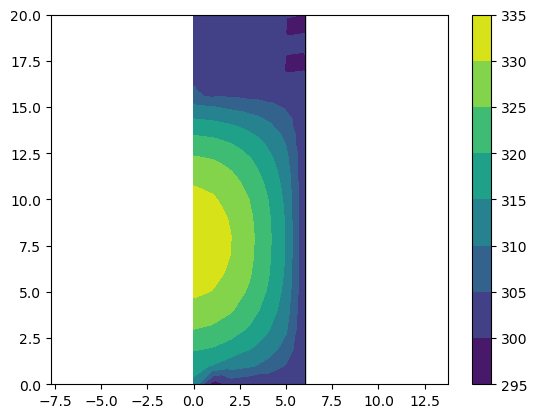

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# converts quad elements into tri elements
def quads_to_tris(quads):
    tris = [[None for j in range(3)] for i in range(2*len(quads))]
    for i in range(len(quads)):
        j = 2*i
        n0 = quads[i][0]
        n1 = quads[i][1]
        n2 = quads[i][2]
        n3 = quads[i][3]
        tris[j][0] = n0
        tris[j][1] = n1
        tris[j][2] = n2
        tris[j + 1][0] = n2
        tris[j + 1][1] = n3
        tris[j + 1][2] = n0
    return tris

# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements):
    for element in elements:
        x = [nodes_x[element[i]] for i in range(len(element))]
        y = [nodes_y[element[i]] for i in range(len(element))]
        plt.fill(x, y, edgecolor='black', fill=False)

# FEM data=====================
#nodes_x = [0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 3.0, 0.0, 1.0, 2.0, 3.0]
#nodes_y = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0]

nodex   = np.linspace(0, r_blocks, r_blocks + 1)
nodes_x = np.tile(nodex, z_blocks + 1)

nodey   = np.linspace(0, z_blocks, z_blocks + 1).reshape(-1, 1)
nodes_y = np.tile(nodey, r_blocks + 1).ravel()

nodal_values = T

#nodal values of the field we want to plot
#nodal_values = [1.0, 0.9, 1.1, 0.9, 2.1, 2.1, 0.9, 1.0, 1.0, 0.9, 0.8]
#table of connectivity of elements
#triangular elements
# elements_tris = [[2, 6, 5], [5, 6, 10], [10, 9, 5]]
#square elements

elements_quads = np.array([[r_step + z_step * (r_blocks + 1),
                            r_step + 1 + z_step * (r_blocks + 1),
                            r_step + 1 + (z_step + 1) * (r_blocks + 1),
                            r_step + (z_step + 1) * (r_blocks + 1)] 
                
                            for z_step in range(0, z_blocks) 
                            for r_step in range(0, r_blocks)])


# elements_quads = [[0, 1, 4, 3], [1, 2, 5, 4], [3, 4, 8, 7], [4, 5, 9, 8]]
#========================================================================

elements = elements_quads


# convert all elements into triangles
#elements_all_tris = elements_tris + quads_to_tris(elements_quads)

elements_all_tris = quads_to_tris(elements_quads)

# create an unstructured triangular grid instance
triangulation = tri.Triangulation(nodes_x, nodes_y, elements_all_tris)


# plot the finite element mesh
plot_fem_mesh(nodes_x, nodes_y, elements)

# plot the contours
plt.tricontourf(triangulation, nodal_values)

# show
plt.colorbar()
plt.axis('equal')
plt.show()

In [125]:
np.zeros((2, 3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [126]:
a = np.array([0.1, 0.2, 0.5])

In [127]:
(a > 0.1).any()

True

In [128]:
a = [1, 2, 3]
b  = [3, 4, 5]

print(list(zip(a, b)))

[(1, 3), (2, 4), (3, 5)]
